# Bayesian Dynamic TWFE

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from patsy import dmatrix
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [2]:
filepath = '../../../../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   island_ids                1900 non-null   int64  
 1   years                     1900 non-null   int64  
 2   region_codes              1900 non-null   object 
 3   prefecture_codes          1900 non-null   int64  
 4   populations               1697 non-null   float64
 5   treatment_group           1900 non-null   int64  
 6   treatment_group_mainland  1900 non-null   int64  
 7   year_bridges_opened       1900 non-null   int64  
 8   after_treated             1900 non-null   int64  
 9   year_connect_mainland     1900 non-null   int64  
 10  after_treated_mainland    1900 non-null   int64  
 11  income                    1401 non-null   float64
 12  area_km2                  1900 non-null   float64
 13  distance_m                1900 non-null   float64
 14  elementa

## Dynamic TWFE

$$
Y_{it} = \alpha_i + \lambda_t + \sum_{l \in L} \delta_l \mathbf{1}[t - k_i = l] + \epsilon_{it}
$$

### ベイズモデル

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pymc/model/core.py:1359: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


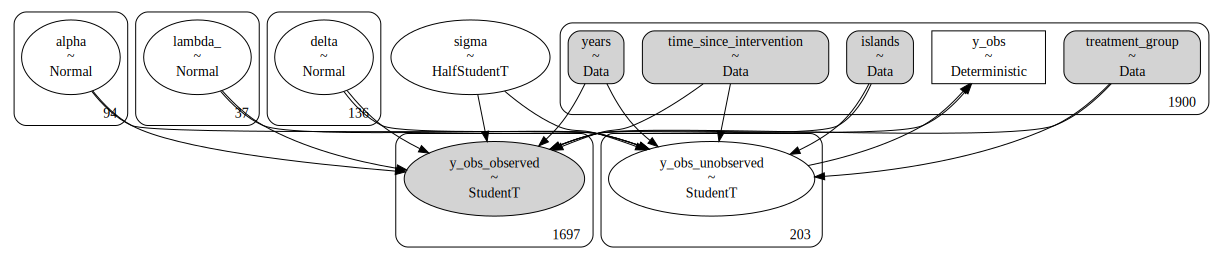

In [8]:
# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['years'], unique_years = pd.factorize(df['years'])

with pm.Model() as dynamic_twfe:
    # data
    islands = pm.Data('islands', df['island_ids'])
    years = pm.Data('years', df['years'])
    treatment_group = pm.Data('treatment_group', df['treatment_group'])
    time_since_intervention = pm.Data('time_since_intervention', df['time_since_intervention'])

    # priors
    alpha = pm.Normal('alpha', mu=0, sigma=100, shape=len(df['island_ids'].unique()))
    lambda_ = pm.Normal('lambda_', mu=0, sigma=100, shape=len(df['years'].unique()))
    delta = pm.Normal('delta', mu=0, sigma=100, shape=len(df['time_since_intervention'].unique()))
    sigma = pm.HalfStudentT('sigma', nu=3, sigma=100)

    # expectation
    mu = alpha[islands] + lambda_[years] + delta[time_since_intervention] * treatment_group

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=3, mu=mu, sigma=sigma, observed=df['populations'])

pm.model_to_graphviz(dynamic_twfe)

In [9]:
with dynamic_twfe:
    trace_dynamic_twfe = pm.sample(
        draws=1000,
        tune=1000,
        chains=2,
        cores=6,
        nuts_sampler='numpyro',
        random_seed=42
    )
    pm.compute_log_likelihood(trace_dynamic_twfe)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Output()

In [33]:
az.summary(trace_dynamic_twfe, var_names=['delta', 'sigma'], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
delta[0],168.244,52.598,68.994,271.152,1.016,0.741,2684.0,1675.0,1.0
delta[1],96.754,50.185,5.054,199.226,1.004,0.844,2525.0,1408.0,1.0
delta[2],77.774,45.199,-8.397,166.929,0.985,0.734,2096.0,1688.0,1.0
delta[3],30.947,48.793,-62.811,129.135,0.850,0.944,3280.0,1662.0,1.0
delta[4],34.132,53.396,-71.024,135.875,1.034,1.165,2846.0,1411.0,1.0
...,...,...,...,...,...,...,...,...,...
delta[132],128.752,50.802,33.297,230.075,0.980,0.764,2703.0,1522.0,1.0
delta[133],111.274,43.894,27.507,196.781,0.935,0.675,2212.0,1761.0,1.0
delta[134],64.196,51.089,-41.079,154.188,0.832,0.762,3658.0,1519.0,1.0
delta[135],121.848,51.913,26.808,226.692,0.967,0.715,2914.0,1433.0,1.0


/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'lambda_'}>,
        <Axes: title={'center': 'lambda_'}>],
       [<Axes: title={'center': 'delta'}>,
        <Axes: title={'center': 'delta'}>],
       [<Axes: title={'center': 'y_obs_unobserved'}>,
        <Axes: title={'center': 'y_obs_unobserved'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'y_obs'}>,
        <Axes: title={'center': 'y_obs'}>]], dtype=object)

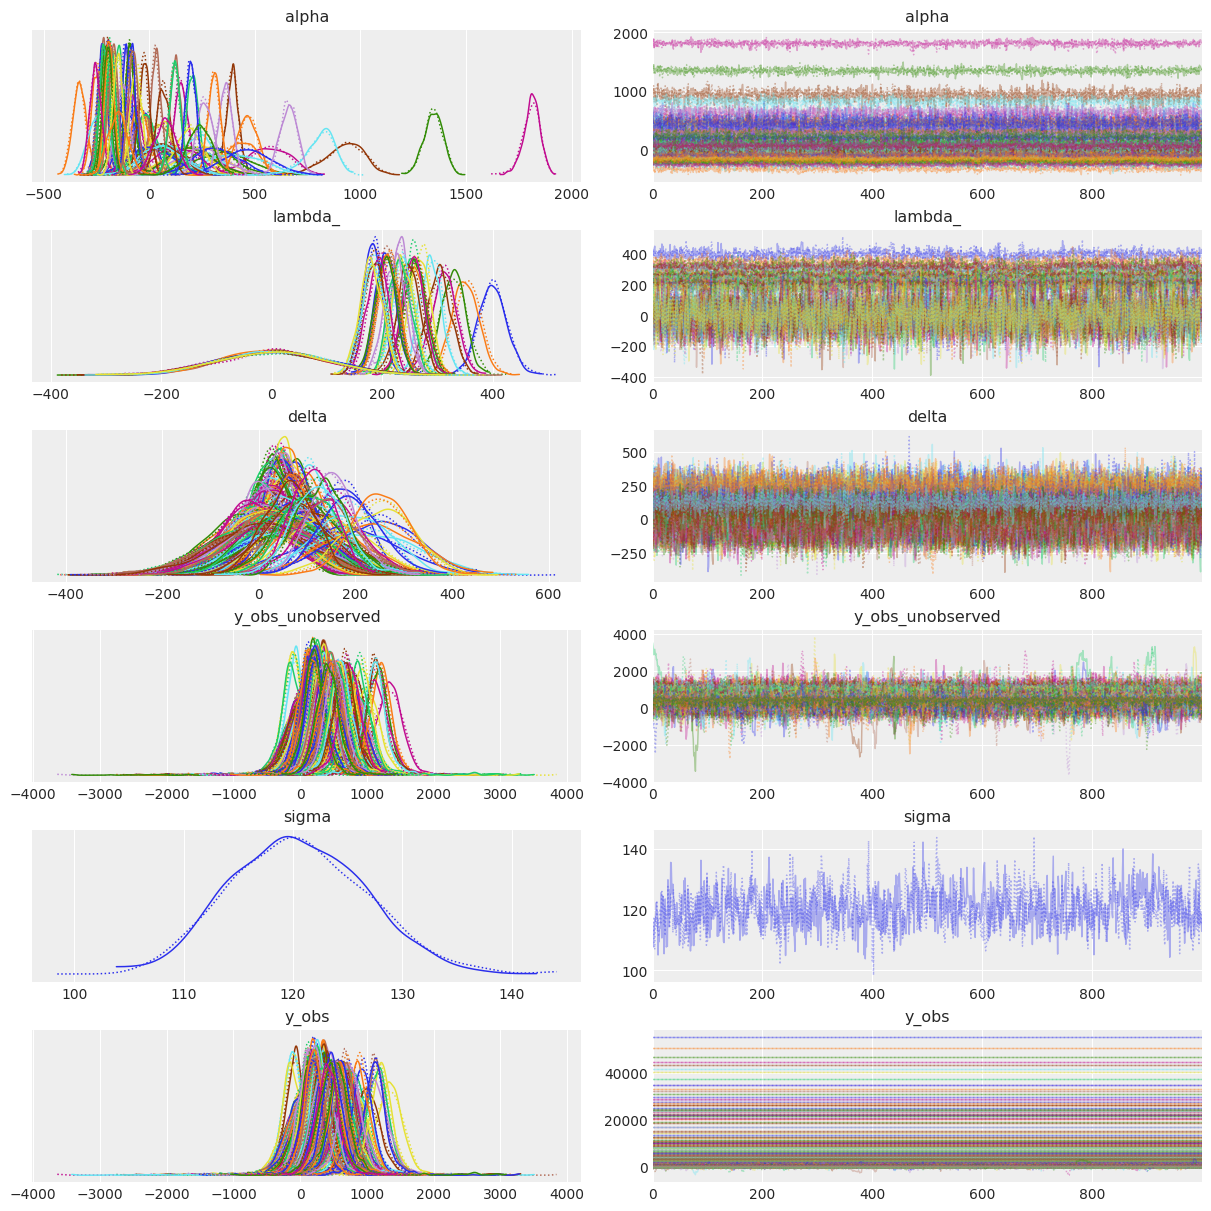

In [12]:
az.plot_trace(trace_dynamic_twfe);

In [11]:
az.loo(trace_dynamic_twfe)

Computed from 2000 posterior samples and 1697 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -13428.18   183.96
p_loo      124.99        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     1697  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [25]:
az.waic(trace_dynamic_twfe)

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 2000 posterior samples and 1697 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -13427.61   183.97
p_waic      124.41        -

There has been a warning during the calculation. Please check the results.

In [15]:
def get_delta_df(trace):
    # デルタのサマリーを取得
    delta_df = az.summary(trace, var_names=['delta'], hdi_prob=0.95, kind='stats')

    # 経過年数
    time_since_intervention_list = df['time_since_intervention'].unique()
    time_since_intervention_df = pd.DataFrame(time_since_intervention_list, columns=['time_since_intervention'])

    # デルタの値を経過年数と結合
    # デルタの順番は経過年数の昇順ではなく，データに登場した順番になっている．
    delta_df.reset_index(drop=True, inplace=True)
    delta_df = pd.concat([delta_df, time_since_intervention_df], axis=1)

    return delta_df

def plot_effects_over_time(delta_df):
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        x='time_since_intervention',
        y='mean',
        data=delta_df,
        marker='o',
        color='black',
        label='Mean'
    )
    # エラーバー
    plt.errorbar(
        x=delta_df['time_since_intervention'],
        y=delta_df['mean'],
        yerr=[
            delta_df['mean'] - delta_df['hdi_2.5%'],
            delta_df['hdi_97.5%'] - delta_df['mean']
        ],
        fmt='o',
        color='black',
        alpha=0.5,
        capsize=5,
        label='95% HDI'
    )
    plt.axvline(x=0, color='black', linestyle=':')
    plt.axhline(y=0, color='black', linestyle=':')
    plt.xlabel('Time since Treatment')
    plt.ylabel('Effects')
    plt.title('Effects Over Time')
    plt.legend()
    plt.show()

### 階層ベイズモデル

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pymc/model/core.py:1359: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


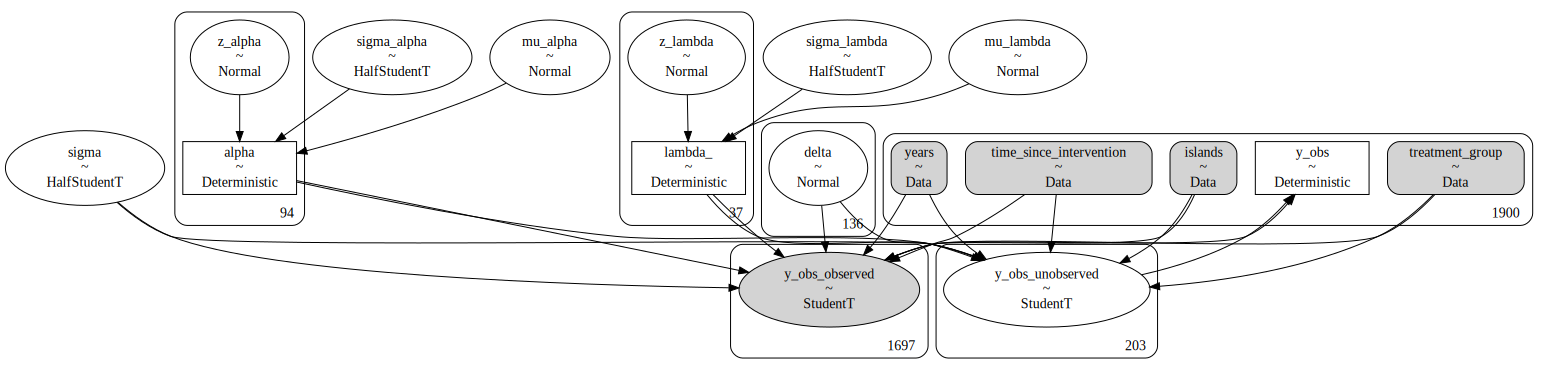

In [3]:
# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['years'], unique_years = pd.factorize(df['years'])

with pm.Model() as dynamic_twfe_h:
    # data
    islands = pm.Data('islands', df['island_ids'])
    years = pm.Data('years', df['years'])
    treatment_group = pm.Data('treatment_group', df['treatment_group'])
    time_since_intervention = pm.Data('time_since_intervention', df['time_since_intervention'])

    # priors
    mu_alpha = pm.Normal('mu_alpha', mu=0, sigma=100)
    sigma_alpha = pm.HalfStudentT('sigma_alpha', nu=3, sigma=100)
    z_alpha = pm.Normal('z_alpha', mu=0, sigma=1, shape=len(df['island_ids'].unique()))
    alpha = pm.Deterministic('alpha', mu_alpha + sigma_alpha * z_alpha)

    mu_lambda = pm.Normal('mu_lambda', mu=0, sigma=100)
    sigma_lambda = pm.HalfStudentT('sigma_lambda', nu=3, sigma=100)
    z_lambda = pm.Normal('z_lambda', mu=0, sigma=1, shape=len(df['years'].unique()))
    lambda_ = pm.Deterministic('lambda_', mu_lambda + sigma_lambda * z_lambda)

    delta = pm.Normal('delta', mu=0, sigma=100, shape=len(df['time_since_intervention'].unique()))
    sigma = pm.HalfStudentT('sigma', nu=3, sigma=100)

    # expectation
    mu = alpha[islands] + lambda_[years] + delta[time_since_intervention] * treatment_group

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=3, mu=mu, sigma=sigma, observed=df['populations'])

pm.model_to_graphviz(dynamic_twfe_h)

In [4]:
with dynamic_twfe_h:
    trace_dynamic_twfe_h = pm.sample(
        draws=1000,
        tune=1000,
        chains=2,
        cores=6,
        nuts_sampler='numpyro',
        random_seed=42
    )

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [5]:
az.summary(trace_dynamic_twfe_h, var_names=['delta', 'sigma'], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
delta[0],17.800,42.459,-56.989,107.320,0.920,0.815,2130.0,1440.0,1.00
delta[1],-23.117,34.345,-88.617,46.483,0.779,0.619,1946.0,1482.0,1.00
delta[2],-39.326,32.138,-101.758,23.730,0.801,0.587,1625.0,1450.0,1.00
delta[3],-62.107,32.683,-126.564,2.045,0.761,0.596,1842.0,1500.0,1.00
delta[4],-54.834,40.516,-141.922,16.760,0.948,0.706,1833.0,1320.0,1.00
...,...,...,...,...,...,...,...,...,...
delta[132],52.467,34.924,-25.219,114.161,0.773,0.600,2016.0,1351.0,1.00
delta[133],30.310,29.841,-30.104,85.504,0.730,0.574,1675.0,1275.0,1.00
delta[134],-27.949,31.958,-94.619,30.006,0.741,0.581,1864.0,1538.0,1.00
delta[135],-11.961,33.711,-76.425,53.059,0.803,0.702,1798.0,1691.0,1.00


/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


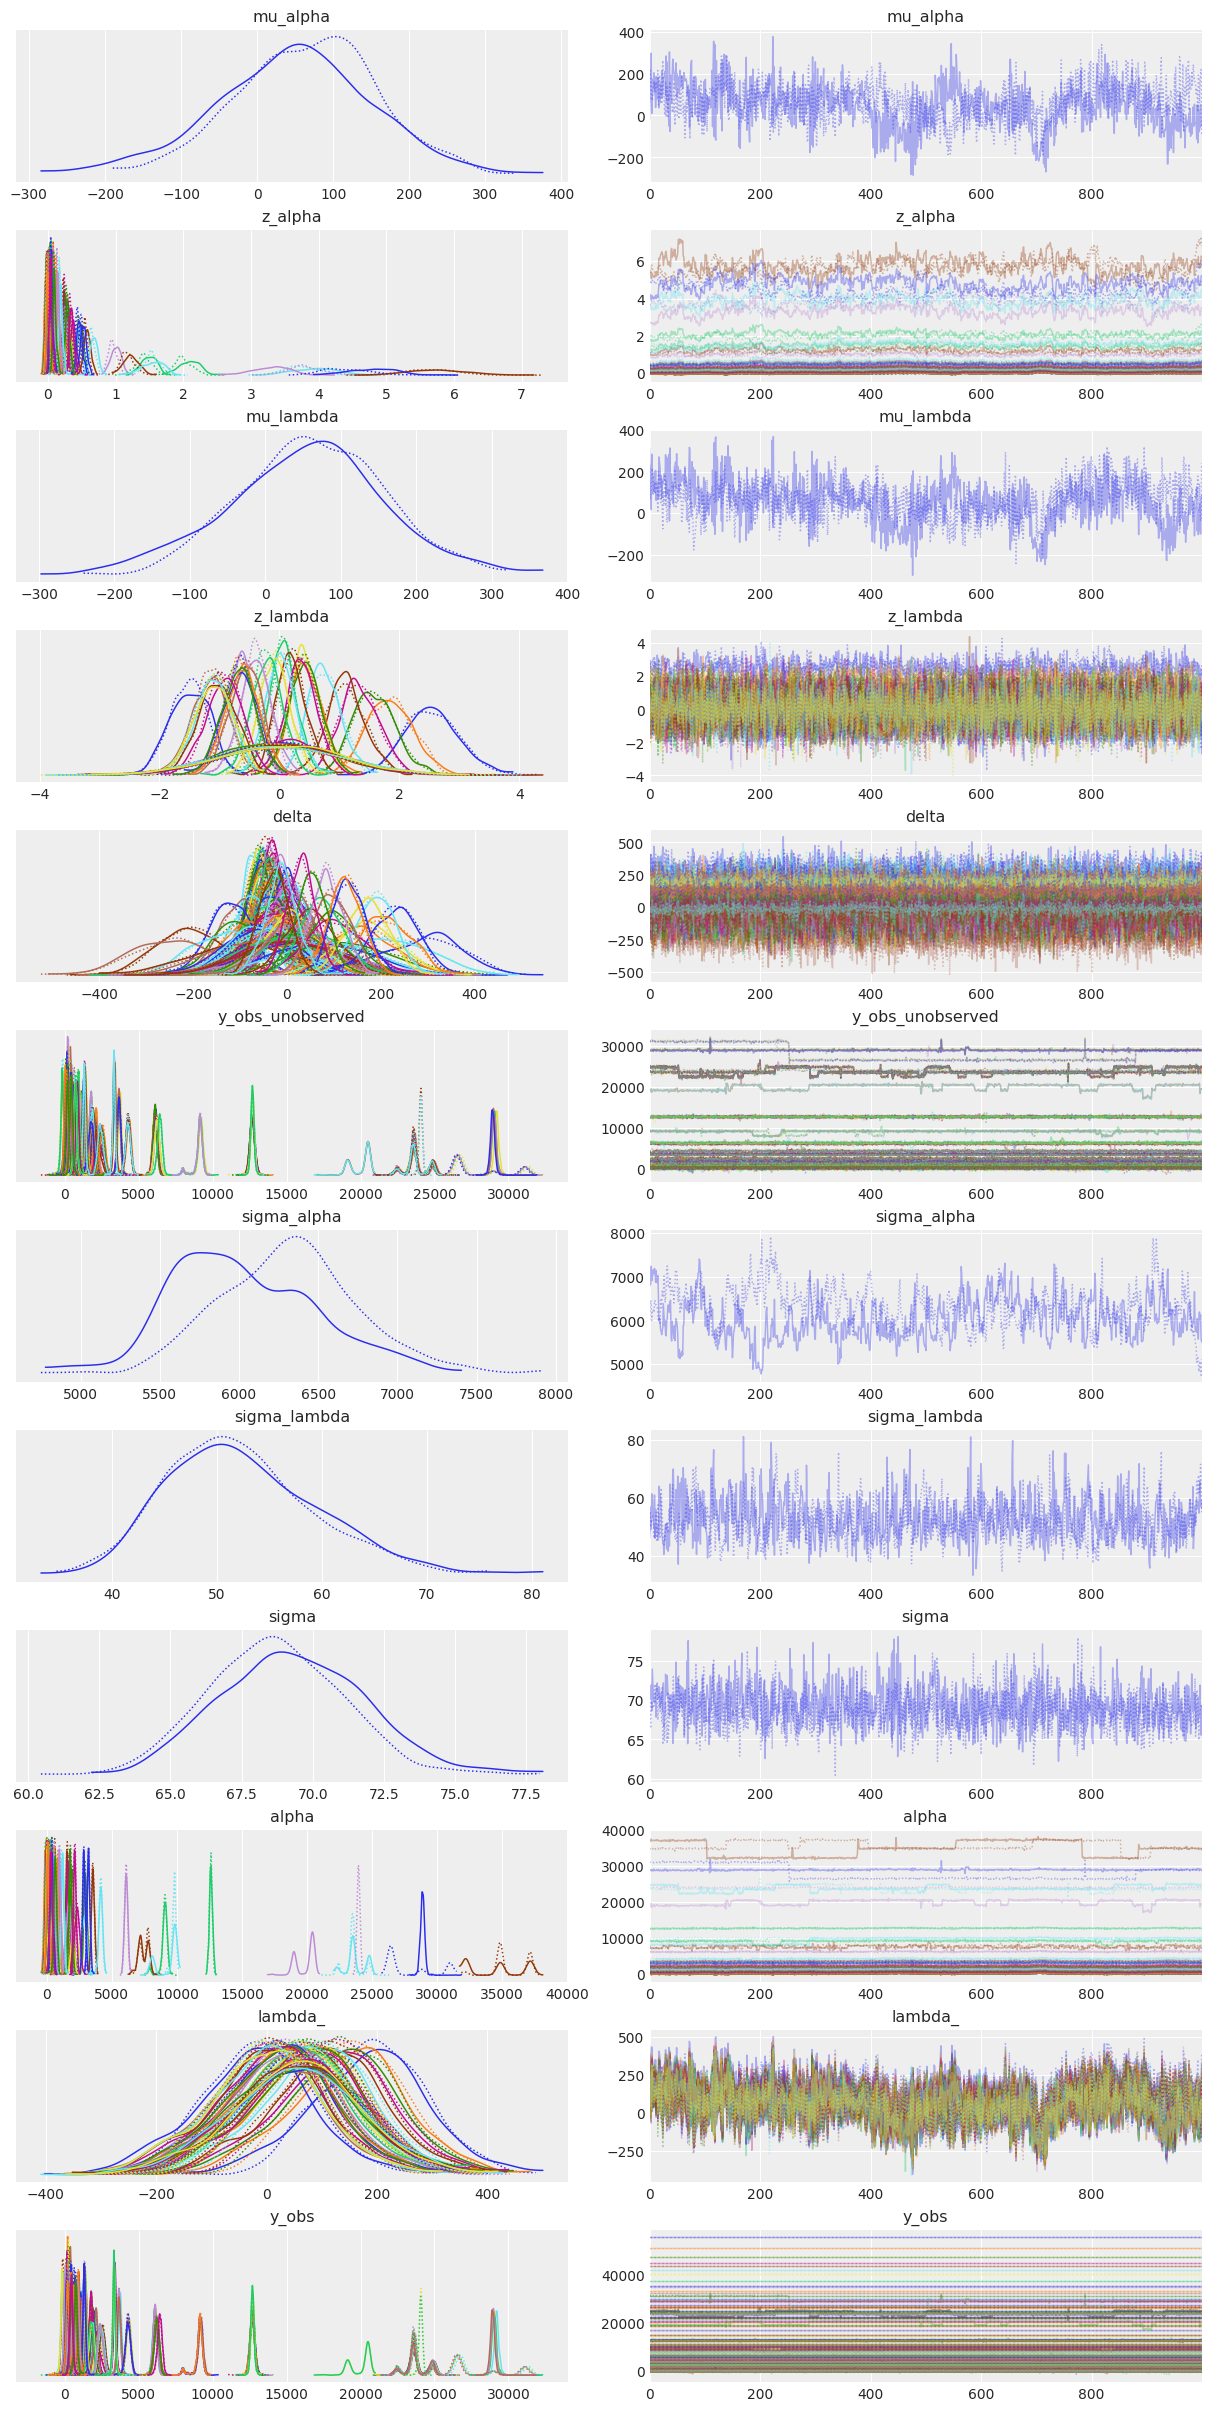

In [6]:
az.plot_trace(trace_dynamic_twfe_h);

In [7]:
with dynamic_twfe_h:
    pm.compute_log_likelihood(trace_dynamic_twfe_h)

az.loo(trace_dynamic_twfe_h)

Output()

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 2000 posterior samples and 1697 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -11710.22   142.60
p_loo      560.14        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     1688   99.5%
   (0.70, 1]   (bad)         4    0.2%
   (1, Inf)   (very bad)    5    0.3%

In [23]:
az.waic(trace_dynamic_twfe_h)

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 2000 posterior samples and 1697 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -11948.83   175.69
p_waic      798.75        -

There has been a warning during the calculation. Please check the results.

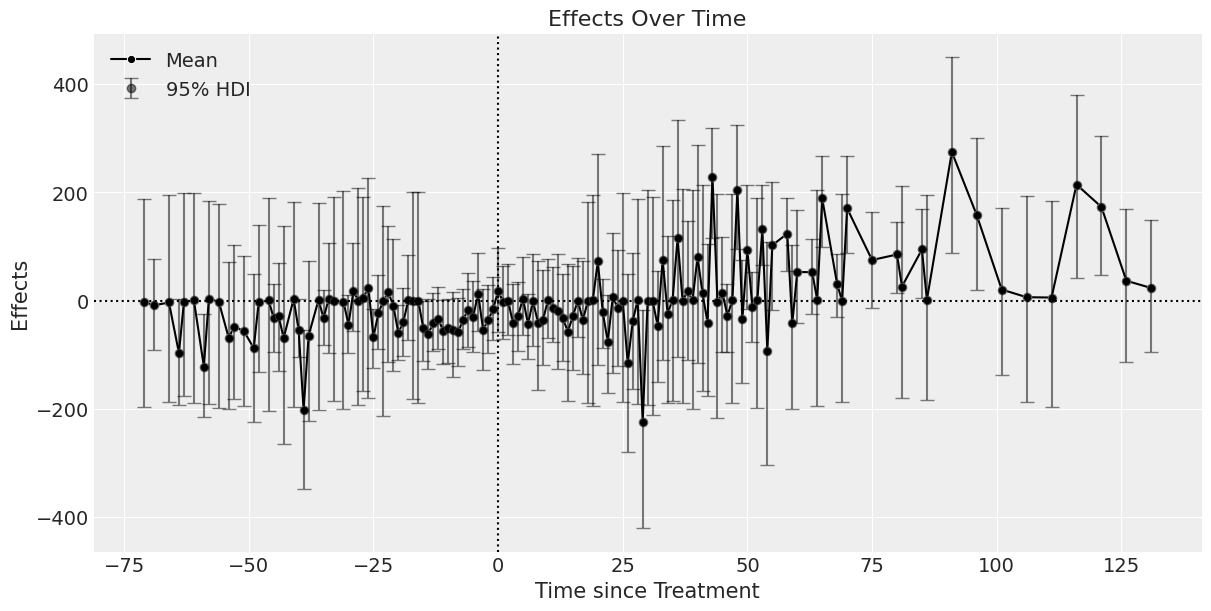

In [17]:
delta_df = get_delta_df(trace_dynamic_twfe_h)
plot_effects_over_time(delta_df)

## サンプリングの保存

In [24]:
az.to_netcdf(trace_dynamic_twfe, './sample/trace_dynamic_twfe.nc')
az.to_netcdf(trace_dynamic_twfe_h, './sample/trace_dynamic_twfe_h.nc')

'./sample/trace_dynamic_twfe_h.nc'